<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

 Установим и импортируем необходимые библиотеки.

In [1]:
import os
import warnings
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
                              RandomForestRegressor,
                              GradientBoostingRegressor)

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import (train_test_split,
                                     RandomizedSearchCV,
                                     TimeSeriesSplit)
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import (
    StandardScaler, 
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

RANDOM_STATE=42

Импортируем датасет, изменив формат дат на datetime и установив этот столбец в качестве индекса.

In [2]:
file_path = '/datasets/taxi.csv'
second_file_path = '/Users/polina.piskovatskova/Documents/YP/datasets/Taxi/taxi.csv'

if os.path.exists(file_path):
    taxi = pd.read_csv(file_path, parse_dates=['datetime']).set_index('datetime')
elif os.path.exists(second_file_path):
    taxi = pd.read_csv(second_file_path, parse_dates=['datetime']).reset_index().set_index('datetime')
else:
    print('Файл не найден')
taxi = taxi.sort_index()
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Проверим, в правильном ли порядке расположены записи в датафрейме.

In [3]:
if taxi.index.is_monotonic == True:
    print('Дата и время заказов расположены в правильном порядке')
else:
    print('Дата и время заказов расположены в неправильном порядке')
taxi.info()

Дата и время заказов расположены в правильном порядке
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
taxi['num_orders'].isna().sum()

0

Данные по количеству заказов приведены в хронологическом порядке с 1 марта 2018 года по 31 августа 2018 года.  
Проведем ресемплирование данных по 1 часу.   

In [5]:
taxi = taxi.resample('1H').sum()

#taxi['rolling_mean'] = taxi.rolling(30).mean() 

In [6]:
taxi['num_orders'].describe()

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64

Минимальное количество заказов - 0, максимальное - 462. Медианное количество заказов: 78. Аномальных значений не наблюдается.

## Анализ

Визуализируем данные.

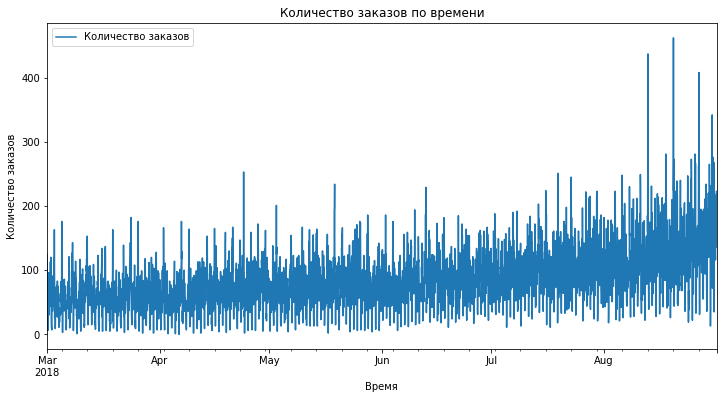

In [7]:
# Построим график
ax = taxi['num_orders'].plot(figsize=(12, 6), title='Количество заказов по времени', label='Количество заказов')
#taxi['rolling_mean'].plot(ax=ax, label='Скользящее среднее', color='red', linestyle='--')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.legend()
plt.show()

Предварительно можно наблюдать тренд на увеличение заказов с течением времени - увеличение среднего числа заказов, т.е временной ряд нестационарный.  
Проверим сезонность количества заказов. Для этого разложим временной ряд на компоненты тренда, сезонности и остатков.

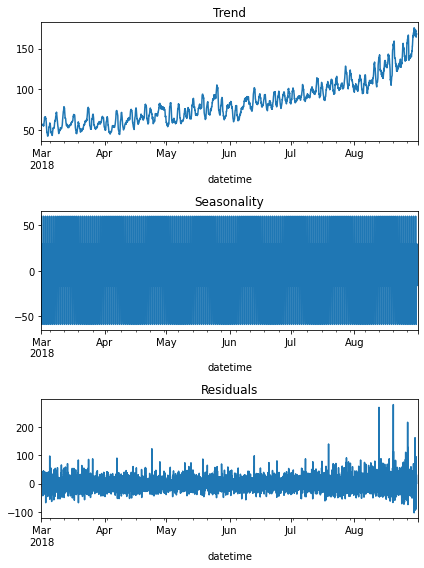

In [8]:
decomposed = seasonal_decompose(taxi)
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Тренд на увеличение количества заказов с течением времени действительно существует.  
Изучим сезонность далее за меньшие промежутки времени.

<AxesSubplot:xlabel='datetime'>

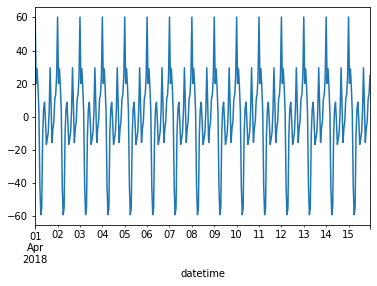

In [9]:
decomposed.seasonal['2018-04-01':'2018-04-15'].plot()

Сезонности, связанной с днем недели, выявить не получается.

<AxesSubplot:xlabel='datetime'>

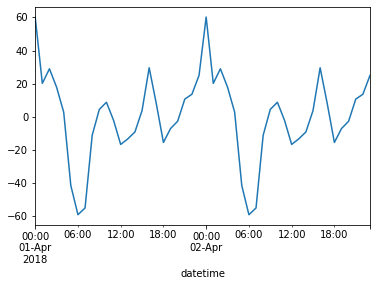

In [10]:
decomposed.seasonal['2018-04-01':'2018-04-02'].plot()

Сезонность связана со временем суток. Максимальное количество заказов такси наблюдается ближе к полуночи, минимальное - в 6 утра.

Определим значимые для моделирования лаги. Для этого используем автокорреляционную функцию ACF и частичную автокорряляционную функцию PACF.

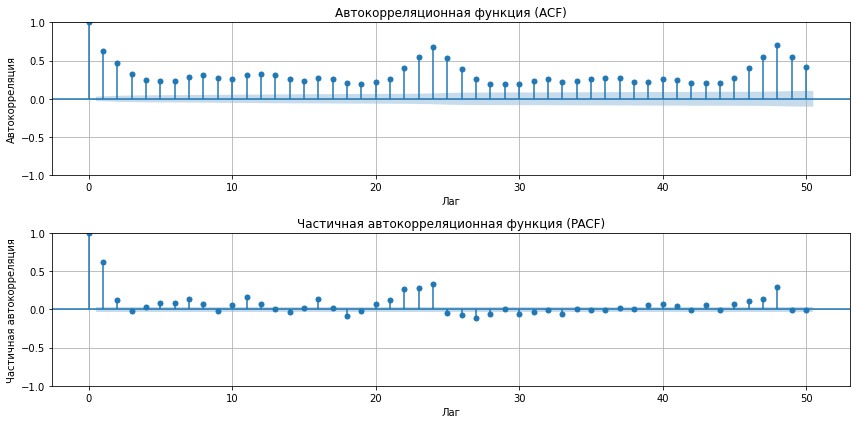

In [11]:
warnings.filterwarnings('ignore')
# Построение графиков ACF и PACF
plt.figure(figsize=(12, 6))

# ACF
plt.subplot(2, 1, 1)
plot_acf(taxi['num_orders'], lags=50, ax=plt.gca())  # Анализ первых 50 лагов
plt.title('Автокорреляционная функция (ACF)')
plt.xlabel('Лаг')
plt.ylabel('Автокорреляция')
plt.grid(True)

# PACF
plt.subplot(2, 1, 2)
plot_pacf(taxi['num_orders'], lags=50, ax=plt.gca())
plt.title('Частичная автокорреляционная функция (PACF)')
plt.xlabel('Лаг') 
plt.ylabel('Частичная автокорреляция')

plt.tight_layout()
plt.grid(True)
plt.show()

ACF Показывает общую корреляцию между количеством заказов и их лагами. Если значения выходят за пределы синей области (доверительный интервал), это указывает на значимую корреляцию. Высокая корреляция наблюдается для значений 0 (само с собой), 1 (значение на 1 шаг назад), 2 часа, 24 и 48 часов - суточная сезонность.
PACF Показывает "чистую" корреляцию между наблюдениями и их лагами, исключая влияние промежуточных лагов.
Добавим значимые лаги в данные. Скользящее среднее возьмем кратным сезонности в сутки - 24 часа.

## Обучение

Для обучения модели создадим дополнительные признаки, с помощью которых можно будет спрогнозировать количество заказов. Добавим лаги, скользящее среднее, день и час.

In [12]:
# Определим функцию для добавления новых признаков
def make_features(df, rolling_mean_size=24):
    data = df.copy()
    # Лаги
    for lag in [1, 2, 24, 48]: 
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)
    
    # Rolling mean
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

    # Признаки даты и времени
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    return data.dropna()
# Добавим признаки в датасет
data = make_features(taxi)
data.head()

,num_orders,lag_1,lag_2,lag_24,lag_48,rolling_mean,day,dayofweek,hour
datetime,,,,,,,,,
2018-03-03 00:00:00,163,72.0,119.0,90.0,124.0,62.750000,3,5,0
2018-03-03 01:00:00,108,163.0,72.0,120.0,85.0,65.791667,3,5,1
2018-03-03 02:00:00,25,108.0,163.0,75.0,71.0,65.291667,3,5,2
2018-03-03 03:00:00,64,25.0,108.0,64.0,66.0,63.208333,3,5,3
2018-03-03 04:00:00,44,64.0,25.0,20.0,43.0,63.208333,3,5,4


Определим данные для обучения и тестирования в соотношении 90:10.

In [19]:
# Определяем тренировочные и тестовые данные в соотношении 90:10
train, test = train_test_split(
    data, test_size=0.1, shuffle=False, random_state=RANDOM_STATE
)
train.dropna()

# Целевой признак
target = 'num_orders'

# Входные признаки
features = list(data.columns.drop('num_orders'))

print("Размер обучающей выборки:", train[features].shape)
print("Размер тестовой выборки:", train[target].shape)

Размер обучающей выборки: (3931, 8)
Размер тестовой выборки: (3931,)


In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3931 entries, 2018-03-03 00:00:00 to 2018-08-13 18:00:00
Freq: H
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    3931 non-null   int64  
 1   lag_1         3931 non-null   float64
 2   lag_2         3931 non-null   float64
 3   lag_24        3931 non-null   float64
 4   lag_48        3931 non-null   float64
 5   rolling_mean  3931 non-null   float64
 6   day           3931 non-null   int64  
 7   dayofweek     3931 non-null   int64  
 8   hour          3931 non-null   int64  
dtypes: float64(5), int64(4)
memory usage: 307.1 KB


Подготовим данные для обучения модели, определим словари гиперпараметров моделей.

In [21]:
# Cоздаём пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
     ('num', MinMaxScaler(), features)
    ], 
    remainder='passthrough'
)

In [22]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_features': range(1, 6),
        'models__min_samples_leaf': [3, 5, 7],
        'models__min_samples_split': [5, 10, 15],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [MinMaxScaler(), StandardScaler()]
    },
    
    # словарь для модели RandomForestRegressor()
    {
        'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': [50, 100, 200],
        'models__max_depth': [10, 20, 40],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    # словарь для GradientBoostingRegressor()
    {
        'models': [GradientBoostingRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': [100, 200],
        'models__learning_rate': [0.05, 0.1], 
        'models__max_depth': [5, 7], 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

Для того, чтобы избежать переобучения модели, увеличим количество фолдов при кроссвалидации. 

In [23]:
warnings.filterwarnings("ignore")

# Используем TimeSeriesSplit для корректной кросс-валидации временного ряда
tscv = TimeSeriesSplit(n_splits=10)

# Используем рандомизированный поиск для подбора лучшей модели по метрике RMSE
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(train[features], train[target])


print('Лучшие параметры модели:\n', randomized_search.best_params_)
print('Лучшая метрика модели на тренировочных данных:\n', round((-1) * randomized_search.best_score_, 2))

Лучшие параметры модели:
 {'preprocessor__num': MinMaxScaler(), 'models__n_estimators': 200, 'models__max_depth': 40, 'models': RandomForestRegressor(max_depth=40, n_estimators=200, random_state=42)}
Лучшая метрика модели на тренировочных данных:
 24.17


## Тестирование

In [24]:
# Получение предсказаний на тестовой выборке
predictions = randomized_search.best_estimator_.predict(test[features])
# Вычисление RMSE на тестовой выборке
rmse_test = mean_squared_error(test[target], predictions, squared=False)
print(f"RMSE на тестовых данных: {round(rmse_test, 2)}")

RMSE на тестовых данных: 43.58


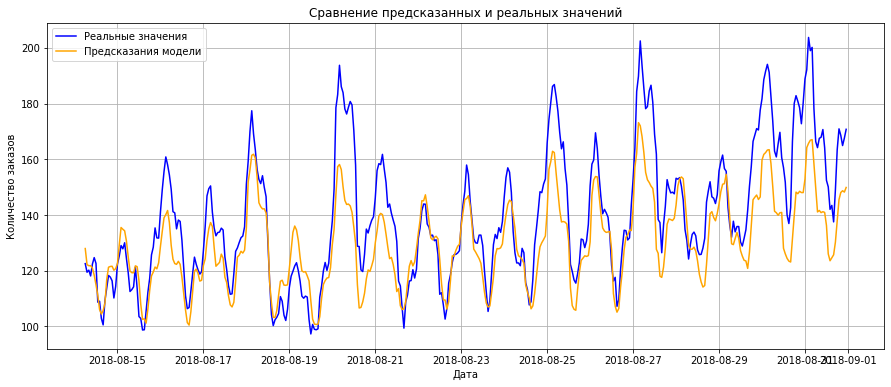

In [30]:
# Вычисление скользящего среднего для сглаживания значений
test_smoothed = test[target].rolling(12).mean()
predictions_smoothed = pd.Series(predictions).rolling(12).mean()

# Визуализация реальных и предсказанных значений тестовой выборки
plt.figure(figsize=(15, 6))
plt.plot(test.index, test_smoothed, label="Реальные значения", color="blue")
plt.plot(test.index, predictions_smoothed, label="Предсказания модели", color="orange")
plt.xlabel("Дата")
plt.ylabel("Количество заказов")
plt.title("Сравнение предсказанных и реальных значений")
plt.legend()
plt.grid()
plt.show()

Модель занижает количество заказов в некоторые дни, когда количество заказов выше среднего. Но расхождение не очень высокое в общем случае.

##  Вывод

1. Подготовка данных  

   Данные о заказах такси в аэропортах загружены, индексированы по времени и проверены на упорядоченность.  
   Проведено ресемплирование по 1 часу.
   Выполнен первичный анализ, выявлены пропуски (их нет).
   
2. Анализ данных  

График количества заказов во времени показывает рост количества заказов, подтверждая наличие тренда.
Разложение ряда выявило тренд и суточную сезонность, с пиковыми значениями ближе к полуночи и минимумами около 6 утра.
Графики ACF и PACF подтвердили значимость лагов 1, 2, 24 и 48 часов.

3. Обучение модели

В данные добавлены новые признаки: лаги (1, 2, 24, 48 часов), скользящее среднее (24 часа) и признаки времени (day, dayofweek, hour).  
Разбиение данных выполнено в пропорции 90:10 для обучения и тестирования моделей.   

Используется Pipeline с предварительной обработкой (StandardScaler, MinMaxScaler, passthrough).  

Протестированы модели:
- DecisionTreeRegressor,
- LinearRegression,
- RandomForestRegressor,
- GradientBoostingRegreassor.  

Во избежание утечки данных для кросс-валидации использовалась TimeSeriesSplit, которая позволяет не смешивать данные обучающей и тестовой выборок по времени. После подбора гиперпараметров с помощью RandomizedSearchCV илучшие результаты показала модель RandomForestRegressor с параметрами:

- Количество деревьев (n_estimators) = 200,
- Глубина деревьев (max_depth) = 40,
- Масштабирование признаков с помощью MinMaxScaler().

Лучшая RMSE модели на тренировочных данных: 24.17.


5. Тестирование   

Метрика RMSE на тестовой выборке составила 43.58, что ниже порога 48. Модель может предсказывать заказы такси в аэропорту для дальнейшего планирования графика водителей и количества машин.
